# Inductive Reasoning vs Deductive Reasoning

Inductive reasoning is noticing a certain set of patterns or rules in a set of data and assuming those patterns or rules apply, while deductive reasoning making a definite 100% conclusion through process of elimination based off of given rules. Example for inductive reasoning: certain countries documented the average lifespan of men and women and found women have a greater average lifespan, so it is reasonable to assume that this will hold for other countries as well. Deductive: proving congruence between 2 triangles with identical angles.

In [226]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from typing import List
from typing import Tuple
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [227]:
df = pd.read_csv('processed.cleveland.csv')

# 2.

In [235]:
def preprocess_data(df: pd.DataFrame, column_names: List[str]) -> pd.DataFrame:

    df.columns = column_names

    df['ca'] = pd.to_numeric(df['ca'], errors='coerce')
    df['thal'] = pd.to_numeric(df['thal'], errors='coerce')

    df['ca'] = df['ca'].fillna(df['ca'].median())
    df['thal'] = df['thal'].fillna(df['thal'].median())

    df['num'] = np.where(df['num'] >= 2, 1, df['num'])

    return df
df = preprocess_data(df, column_names)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
1,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
2,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
3,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
4,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0


# 3

In [239]:
from typing import Tuple
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

def train_and_evaluate_model(df: pd.DataFrame) -> Tuple[str, DecisionTreeClassifier]:
    X = df.drop('num', axis=1)
    y = df['num']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model = DecisionTreeClassifier(
        class_weight='balanced',
        max_features=10, 
        splitter='best',  
        max_depth=7, 
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)
    return report, model
report, model = train_and_evaluate_model(df)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.81      0.82        48
           1       0.80      0.81      0.80        43

    accuracy                           0.81        91
   macro avg       0.81      0.81      0.81        91
weighted avg       0.81      0.81      0.81        91



3 variables were tweaked: class weight, splitter, and max depth. Class weight is set to balanced, allowing the model to oversample the minority class so it can better predict an instance of the minority class. Splitter is set to best, so that the model can make the optimal split at each node for better fitting. Max depth was set to 7 so that the model doesn't overfit to the data and make better general predictions about the dataset.

# 4.

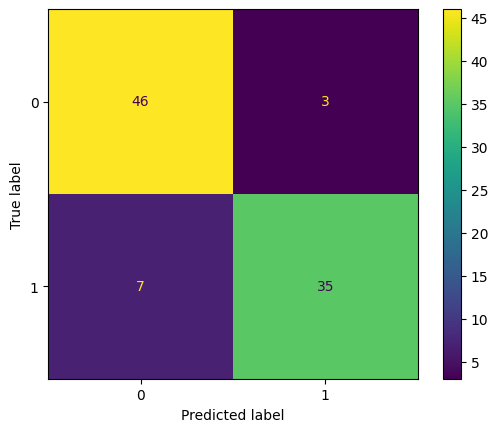

In [240]:
def train_and_evaluate_rf_model(df: pd.DataFrame) -> Tuple[float, RandomForestClassifier]:
    X = df.drop('num', axis=1)
    y = df['num']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    rf = RandomForestClassifier(
        n_estimators=300,         
        max_depth=12,            
        min_samples_split=3,      
        min_samples_leaf=1,       
        class_weight='balanced', 
        random_state=42
    )
    rf.fit(X_train, y_train)
    score = rf.score(X_test, y_test)
    ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
    return score, rf
score, rf = train_and_evaluate_rf_model(df)


In [202]:
#Recall
35/(35+7)

0.8333333333333334

Max depth was again limited to 12 to avoid overfitting, estimators was set to 300 so that more decision trees were created, thus improving the models prediction accuracy. Min samples is 3 so that the model doesn't make an overly specific split (again to avoid overfitting). Min samples leaf was set to 1 so that each split has at least one sample. 

# 5. Create an xgboost model tuned to the best of your abilities. Explain how you tuned it.

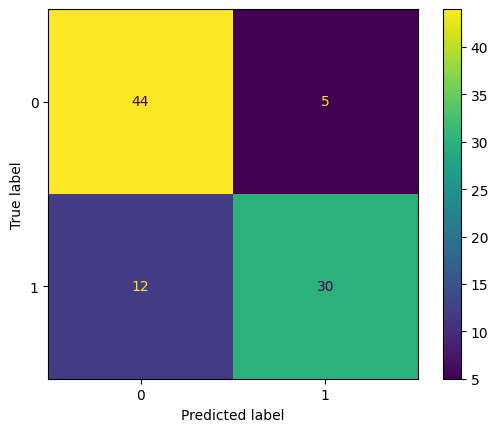

In [241]:
def train_and_evaluate_xgb_model(df: pd.DataFrame) -> Tuple[XGBClassifier, pd.Series]:
    X = df.drop('num', axis=1)
    y = df['num']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    xgb = XGBClassifier(
        n_estimators=300,          
        max_depth=10,
        gamma=1
    )
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    ConfusionMatrixDisplay.from_estimator(xgb, X_test, y_test)
    return xgb, y_pred
xgb, y_pred = train_and_evaluate_xgb_model(df)

In [242]:
#Recall
30/(30+12)

0.7142857142857143

Same as the other ones except there is a new gamma parameter. It "punishes" the model whenever it makes a split and only improves the accuracy by a small margin, to limit the samples more organically and let the model decide what is the optimal depth.